<a href="https://colab.research.google.com/github/AlandouglasMendes/notebooks/blob/master/Mpg%20in%201970's%20cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is  a notebook showing the solution for a regression problem.
## We will use Keras to predict the "miles per gallon" and the "km/L" of some model cars from the 1970's, using physical data from the cars, like size and mass.

Thi is a notebook in  wich will run a neural network to solve a regression problem, using [keras](https://keras.io/)/[tensorflow](https://www.tensorflow.org/). It's an exercise in the tensorflow course offered by [udacity](https://www.udacity.com). 
The first step is installing [seaborn](https://seaborn.pydata.org/) in the notebook, using [pip](https://pypi.org/project/pip/) (we have to use ```!pip``` instead of  ```pip``` ).

#System preparation
Some installs to run and build our model.

In [0]:
!pip install seaborn

Now we have to make some imports to use tools for data manipulation and plotting results

In [0]:
from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0-rc1


#Data obtaining and filtering

Getting data and verifying it.

Now we have to download the dataset. Is available at [UCI Machine learning repository](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

In [0]:
dataset_path = keras.utils.get_file('auto-mpg.data', 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dataset_path


'/root/.keras/datasets/auto-mpg.data'

Now, to import the data we wish using [Pandas](https://pandas.pydata.org/).

In [0]:
column_names = ['MPG', 'Cilinders','Displacement','Horse power','Weight','Acceleration','Model year','Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t', sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cilinders,Displacement,Horse power,Weight,Acceleration,Model year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Data does not always comes as we wish(it almost never does, actually), so we will manipulate them to make
some cleaning.
We will look for unknown values:

In [0]:
dataset.isna().sum()

MPG             0
Cilinders       0
Displacement    0
Horse power     6
Weight          0
Acceleration    0
Model year      0
Origin          0
dtype: int64

And we will cut this ones out, there are only 6 of them.

In [0]:
dataset = dataset.dropna()


#Data manipulation
Some transformations in order to make data fit our tools of analysis

And we have the column origin, wich is a categorical one. No problem, we turn it into a one-hot:

In [0]:
origin = dataset.pop('Origin')

dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan'] = (origin==3)*1.0
dataset.tail()

,MPG,Cilinders,Displacement,Horse power,Weight,Acceleration,Model year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Now, we will split our data in two sets. In one of them, we will find a pattern among the data. on the other, we will see if that pattern is consistent. We do it this way, so our model can find a pattern not only in the data we have but in data it have never seen as well.

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Inspecting the relations among these data:

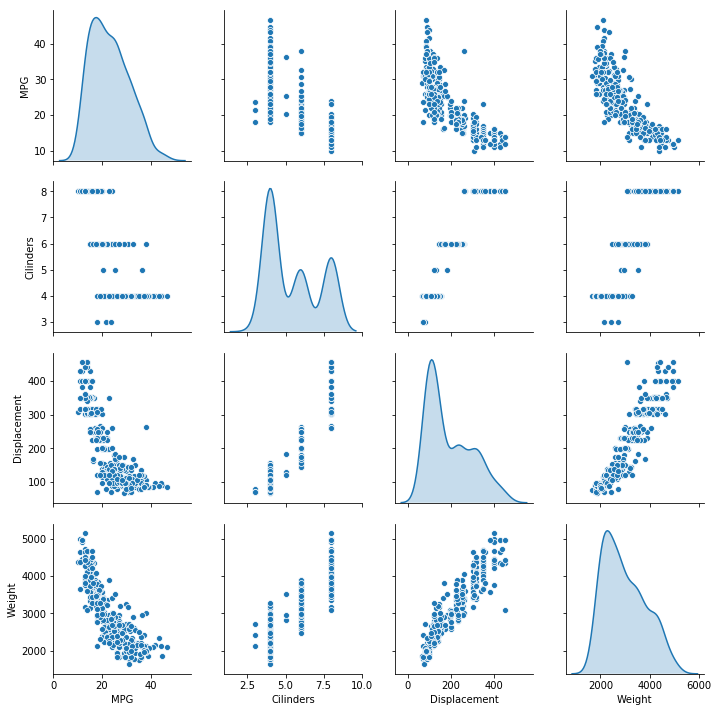

In [0]:
sns.pairplot(train_dataset[["MPG", "Cilinders","Displacement","Weight"]], diag_kind="kde")

An overall statistics:

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cilinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horse power,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


Now, we will remove MPG from the table in order to find a pattern that describes MPG based on the other values.

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

The data has wide range and different values, so we will normalize it. By doing so we will make alll values fall between 0 and 1, what at the same time makes training easier and our model will not depend on the units used in the input.
Not only the training set must be normalized. The test set must be normalized to fit the model distribution.


In [0]:
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Important: All data fed to the model must be normalized. Not only the training set, but the test set and data when the model is used on production.

#Building the model

Now we will run the functions that will build our model

Our model will be a ```sequential``` model with two densely conected layers, and an output layer that returns a single, coninuous value.
the model buildimg steps are wrapped in a function, build model, since we will create a second model, later on.



In [0]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss = 'mse',
             optimizer = optimizer,
             metrics = ['mae','mse'])
  return model
model = build_model()

#Analyzing the bases of the model
Verification of consistency and debugging.

We will see a brief description of the model:

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Now, testing before training, to look for bugs:

In [0]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.03220667],
       [-0.27755862],
       [ 0.00742884],
       [-0.11110833],
       [ 0.03378586],
       [-0.10799855],
       [-0.0130512 ],
       [-0.01513378],
       [-0.03211011],
       [ 0.36927378]], dtype=float32)

#Training the model
Now we will train the model for 1000 epochs, or turns aroud our dataset. And we will be recording the training and validation accuracy in the ```history``` object.



In [0]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
EPOCHS = 1000
history = model.fit(
normed_train_data,
train_labels,
epochs = EPOCHS,
validation_split = 0.2,
verbose=0,
callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail

<bound method NDFrame.tail of            loss  mean_absolute_error  ...  val_mean_squared_error  epoch
0    564.526184            22.495588  ...              551.719604      0
1    508.852466            21.231333  ...              495.538300      1
2    456.607713            19.995363  ...              437.526337      2
3    401.552558            18.612919  ...              374.675568      3
4    343.301161            17.060684  ...              311.683411      4
5    284.701696            15.342610  ...              249.020142      5
6    228.369810            13.510028  ...              192.510162      6
7    176.740600            11.696427  ...              141.918747      7
8    131.711697             9.825296  ...              101.143013      8
9     95.487355             8.059020  ...               71.764336      9
10    69.019632             6.573636  ...               53.281910     10
11    51.093850             5.555251  ...               42.198498     11
12    38.813514      

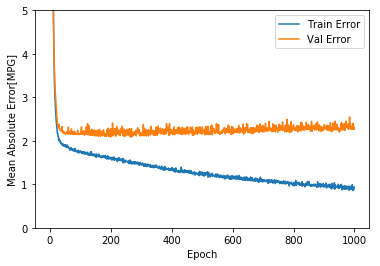

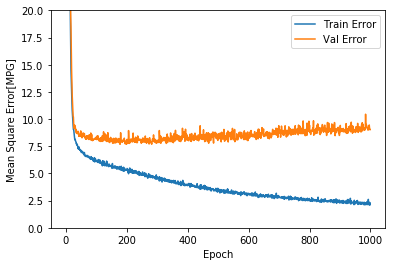

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel('Mean Absolute Error[MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
  plt.legend()
  plt.ylim([0, 5])
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel('Mean Square Error[MPG]')
  plt.plot(hist['epoch'], hist['mean_squared_error'], label ='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val Error')
  plt.legend()
  plt.ylim([0, 20])
plot_history(history)

These are learning curves for each of our metrics. The validation error stopped decreasing very soon, what indicates a over-fitting problem. We will use a method called *EarlyStopping callback*, that tests a training condition for everyepoch. if a set amount of epochs elapses without showing improvement, then automaticaly we stop the training.


...........................................

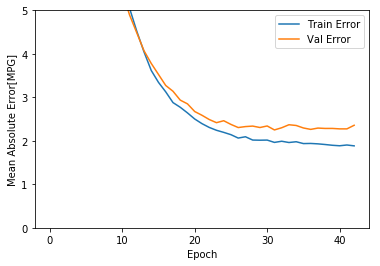

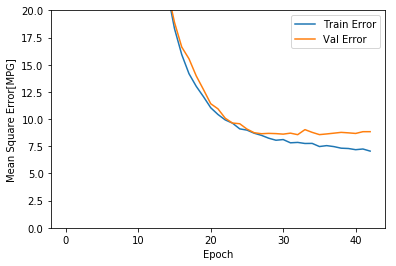

In [0]:
model =build_model()
  #patience is the parameter that says the number of epochs to check for improvement
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(normed_train_data,
                     train_labels,
                     epochs=EPOCHS,
                     validation_split=0.2,
                     verbose=0,
                     callbacks=[early_stop, PrintDot()])
plot_history(history)

Our model has a precision of 2 miles per gallon, and now we will look at our absolute mean error:

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.81 MPG


#Testing our model
Now we will compare our model to the real values so we can see how good is our model in real data.

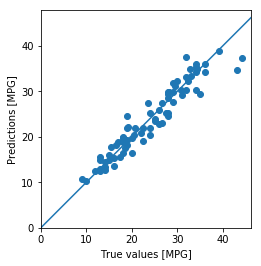

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Now, let's see what our error looks like using an histogram:

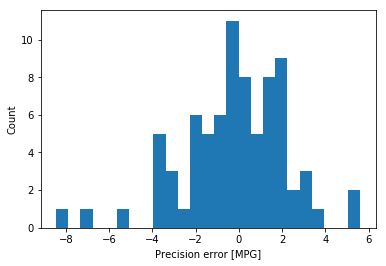

In [0]:
error = test_predictions-test_labels
plt.hist(error, bins=25)
plt.xlabel("Precision error [MPG]")
_ = plt.ylabel("Count")

#Conclusion

Error took the shape of the classical bell curve, with a bigger set, we can see that it would fit the normal distribution, as we waited.
So, our model predicts MPG on a good precision, if you think we watched only its weight and cilinders.